In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import regex as re
from datetime import datetime

df = pd.read_csv("ClimateDataParaguay.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,PA000086033,"BAHIA NEGRA, PA",-20.23,-58.167,96.0,2000-01-04,NaN,33.3,NaN,20.8
1,PA000086033,"BAHIA NEGRA, PA",-20.23,-58.167,96.0,2000-01-08,NaN,32.5,NaN,24.2
2,PA000086033,"BAHIA NEGRA, PA",-20.23,-58.167,96.0,2000-01-13,NaN,33.3,NaN,25.4
3,PA000086033,"BAHIA NEGRA, PA",-20.23,-58.167,96.0,2000-01-14,NaN,32.9,NaN,25.0
4,PA000086033,"BAHIA NEGRA, PA",-20.23,-58.167,96.0,2000-01-22,NaN,35.2,NaN,26.2


In [2]:
df["NAME"].unique() ## ['BAHIA NEGRA, PA', 'ENCARNACION, PA',
                    ## 'SILVIO PETTIROSSI INTERNATIONAL, PA', 'CONCEPCION, PA']

sitios = ["BHN", "ENC", "AEP", "CON"]
estacion = {k:v for k, v in zip(sitios, df["NAME"].unique().tolist())}


## Encontrar missing values por Estacion Meteorologica
def missing_values(estacion):
    df_missing = df.loc[df["NAME"] == estacion, ["DATE", "PRCP", "TAVG", "TMAX", "TMIN"]].set_index(
        "DATE").reindex(pd.date_range("2000-01-01", "2022-12-31"))
    df_missing = df_missing.isna().groupby(df_missing.index.year)
    return df_missing

for x in estacion.values():
    missing = missing_values(x)
    values = missing.agg("mean").sort_values(by="TAVG", ascending=False)
    print(x + "\nPorcentaje faltantes\n{}%".format((missing.sum()/missing.count()*100).mean())
          + "\nAños con más faltantes\n{}".format(dict(zip([data for data in values.iloc[0:5].index],
                                                      [round(value*100,2) for value in values.iloc[0:5]["TAVG"]])))
          +"\n")

BAHIA NEGRA, PA
Porcentaje faltantes
PRCP    91.475898
TAVG    72.774225
TMAX    88.536242
TMIN    76.250077
dtype: float64%
Años con más faltantes
{2017: 100.0, 2016: 100.0, 2015: 100.0, 2014: 100.0, 2008: 100.0}

ENCARNACION, PA
Porcentaje faltantes
PRCP    58.862939
TAVG     7.629541
TMAX    54.624402
TMIN    23.701104
dtype: float64%
Años con más faltantes
{2007: 31.23, 2000: 25.68, 2001: 23.29, 2006: 22.74, 2005: 18.9}

SILVIO PETTIROSSI INTERNATIONAL, PA
Porcentaje faltantes
PRCP    55.029763
TAVG     0.130965
TMAX    62.111750
TMIN    37.212106
dtype: float64%
Años con más faltantes
{2005: 1.37, 2021: 0.55, 2003: 0.27, 2001: 0.27, 2000: 0.27}

CONCEPCION, PA
Porcentaje faltantes
PRCP    61.173090
TAVG     4.929033
TMAX    55.146864
TMIN    13.499513
dtype: float64%
Años con más faltantes
{2007: 17.26, 2005: 15.62, 2006: 13.97, 2001: 12.6, 2003: 8.77}



In [3]:
def temp_df(estacion, group_type, years):
    df_estacion = df.loc[df["NAME"] == estacion, ["DATE", "TAVG", "TMAX", "TMIN"]
                        ].set_index("DATE").reindex(pd.date_range("2000-01-01", "2023-03-01"))
    try:
        years = str(years).strip()
        years = re.split(" |,|:|-", years)
        if len(years[0]) != 4: print("Please use a valid year")
        df_estacion = df_estacion.loc[(pd.date_range(dt.datetime(int(years[0]), 1, 1),
                                                    dt.datetime(int(years[-1]), 12, 31)))]
        df_estacion = df_estacion.loc[~((df_estacion.index.month == 2) & (df_estacion.index.day == 29))]
        df_estacion["YEAR"], df_estacion["MONTH"], df_estacion["DAY"] = df_estacion.index.year, df_estacion.index.month, df_estacion.index.day
    except:
        raise ValueError('Please use " "')
    try:
        if group_type == "year": grupo = df_estacion["YEAR"]
        if group_type == "month": grupo = df_estacion["MONTH"]
        if group_type == "week": grupo = df_estacion.index.isocalendar().week
        if group_type == "day": grupo = [df_estacion["MONTH"], df_estacion["DAY"]]
        #[df_estacion["MONTH"], df_estacion["DAY"]]
    except: return print("Invalid group type \nPlease enter: 'year', 'month', 'week' or 'day'")    

    return df_estacion.groupby(grupo, as_index=False).agg({"TAVG":"mean", "TMAX":"max", "TMIN":"min"})

# test
temp_df(estacion["BHN"], "week", "2012-2022").head()

,TAVG,TMAX,TMIN
0,29.900000,36.2,20.2
1,31.560000,39.4,21.8
2,30.387500,40.0,20.0
3,29.672222,38.4,19.5
4,30.261538,38.8,19.2


Se rompio el record de máxima en 130 días
Se rompio el record de mínima en 109 días


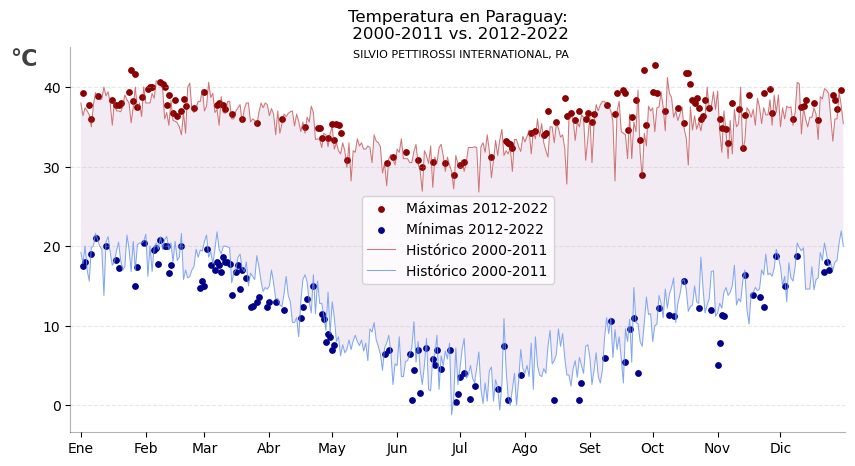

In [5]:
# PLOT LINEA Y SCATTER
#%matplotlib widget
fig, axs = plt.subplots(1,1, figsize=(10,5))

estacion_func = estacion["AEP"]
temp_base = temp_df(estacion_func, "day", "2000-2011")
temp_compare = temp_df(estacion_func, "day", "2012-2022")

tmax1 = temp_base["TMAX"]
tmin1 = temp_base["TMIN"]
tmax2 = temp_compare["TMAX"]
tmin2 = temp_compare["TMIN"]

# grafico de linea para valores max y min
#dates_axis = [x.strftime("%d/%m") for x in pd.date_range("2022-01-01", "2022-12-31")] ## forma de Date en eje X
plt.plot(tmax1, label="Histórico 2000-2011", c="firebrick", alpha=0.6, linewidth=0.75)
plt.plot(tmin1, label="Histórico 2000-2011", c="cornflowerblue", alpha=0.8, linewidth=0.75)
plt.gca().fill_between(range(len(tmax1)), tmax1, tmin1, facecolor="thistle", alpha=0.3)

# scatter plot para temperaturas por encima de max y min
record_high = tmax2[tmax2 > tmax1]
record_low = tmin2[tmin2 < tmin1]
plt.scatter(record_high.index, record_high.values, c="darkred", s=15, label="Máximas 2012-2022")
plt.scatter(record_low.index, record_low, c="darkblue", s=15, label="Mínimas 2012-2022")

handles, labels = plt.gca().get_legend_handles_labels()
legend_order = [2, 3, 0, 1]
plt.legend(handles=[handles[x] for x in legend_order], labels=[labels[x] for x in legend_order],
           loc=0, borderaxespad=2.5)

plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.xlim(-5, 365)
x_ticks = [(x-1) for x in pd.date_range("2022-01-01", "2022-12-31", freq="MS").dayofyear]
plt.gca().set_xticks(ticks=x_ticks, labels=["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Set","Oct","Nov","Dic"])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_alpha(0.3)
plt.gca().spines['left'].set_alpha(0.3)

plt.ylabel("°C", rotation=0, fontsize=16, fontweight=700, alpha=0.75, loc="top", verticalalignment="top")
plt.title("Temperatura en Paraguay:\n 2000-2011 vs. 2012-2022")
plt.suptitle(estacion_func, y=0.875, x=0.5156, size=8, weight=50)
#plt.savefig("ComparativoTemperatura.png")

print("Se rompio el record de máxima en {} días".format(len(record_high)))
print("Se rompio el record de mínima en {} días".format(len(record_low)))

In [7]:
# JUPYTER WIDGETS
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import Box

estacion_func = estacion["CON"]
temp_base = temp_df(estacion_func, "day", "2000-2011")

tmax1 = temp_base["TMAX"]
tmin1 = temp_base["TMIN"]
tavg1 = temp_base["TAVG"]



@interact(TemperaturePy = widgets.IntSlider(
    value=2012,
    min=2012,
    max=2022,
    step=1,
    description="Año"))


#@interact(TemperaturePy = widgets.Checkbox(
#    value=False, description="Acumulado"))

def plot_years(TemperaturePy):
    plt.figure(figsize=[10,5])
    
    plotdf = temp_df(estacion_func, "day", TemperaturePy)
    plt.plot(tavg1)
    plt.ylim(15, 37)
    plt.xlim(-5, 366)
    #plt.plot(plotdf["TAVG"])
    
    x_ticks = [(x-1) for x in pd.date_range("2022-01-01", "2022-12-31", freq="MS").dayofyear]
    plt.gca().set_xticks(ticks=x_ticks, labels=["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Set","Oct","Nov","Dic"]);    
    
    record_avg = plotdf[plotdf["TAVG"] > tavg1]
    plt.scatter([(x-1) for x in record_avg.index], record_avg["TAVG"], s=15, color="darkred");
    

interactive(children=(IntSlider(value=2012, description='Año', max=2022, min=2012), Output()), _dom_classes=('…